In [24]:
import qlty
from qlty import qlty2D
from qlty.qlty2D import NCYXQuilt
from qlty.cleanup import weed_sparse_classification_training_pairs_2D
from qlty.utils import false_color_2D
import skimage
import skimage.data
import matplotlib.pyplot as plt
import umap
import torch
import einops
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.io import imread

In [3]:
class CustomScaler:
    def __init__(self, tau=3.0, feature_range=(0, 1)):
        self.tau = tau
        self.feature_range = feature_range
        self.standard_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler(feature_range=feature_range)

    def fit(self, X):
        # Fit the standard scaler
        self.standard_scaler.fit(X)
        
        # Transform the data with standard scaler and then clip
        X_scaled = self.standard_scaler.transform(X)
        X_clipped = np.clip(X_scaled, -self.tau, self.tau)
        
        # Fit the min-max scaler on the clipped data
        self.minmax_scaler.fit(X_clipped)
        
    def transform(self, X):
        # Apply standard scaling
        X_scaled = self.standard_scaler.transform(X)
        
        # Clip the values
        X_clipped = np.clip(X_scaled, -self.tau, self.tau)
        
        # Apply min-max scaling
        return self.minmax_scaler.transform(X_clipped)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


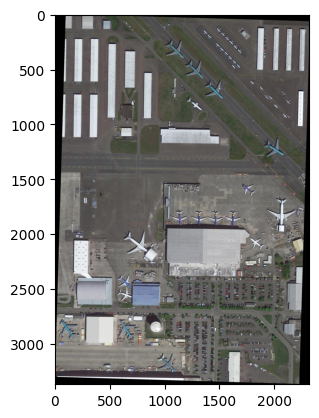

torch.Size([1, 3, 3369, 2319])


In [6]:
#camera_image = skimage.data.camera()
this_image = skimage.io.imread("P0024.png")
plt.imshow(this_image)
plt.show()
imgs = torch.Tensor(this_image.astype(float)) 
imgs = einops.rearrange(imgs, "Y X C -> () C Y X")
print(imgs.shape)

In [11]:
fco_cell = false_color_2D.FalseColorGenerator(image_shape=imgs.shape, 
                                              window_size=16,step_size=16,
                                              scaler=CustomScaler()
                                             )

In [14]:
fco_cell.train_reducer(imgs, num_patches=15000)

torch.Size([15000, 3, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (3, 3369, 2319) for image data

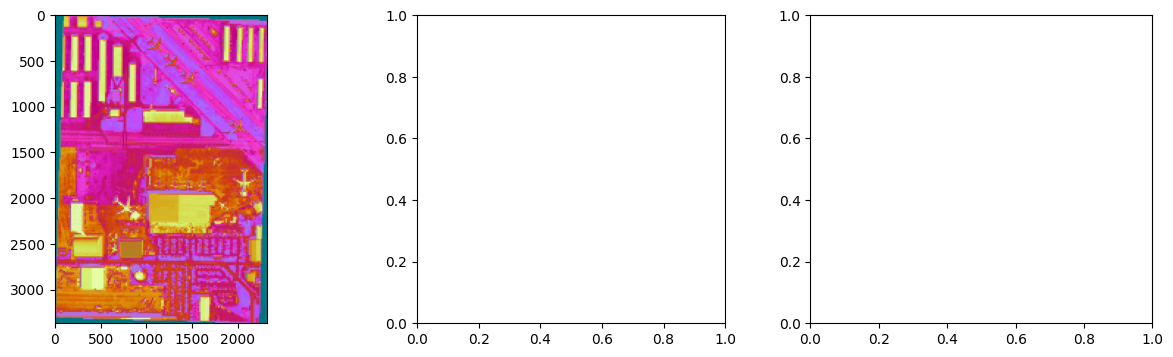

In [16]:
for img in imgs:
    rgb = fco_cell(img.unsqueeze(0))
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    gamma = 1.0
    axs[0].imshow(rgb)    
    axs[1].imshow(img)
    axs[2].imshow(img)
    axs[2].imshow(rgb, alpha=0.5)   
    plt.show()


In [18]:
import napari
viewer = napari.view_image(rgb)
_ = viewer.add_image(this_image)

In [19]:
_ = viewer.add_image(rgb)

In [31]:
labels = viewer.layers["Labels"].data
np.save("aiport_labels3.npy", labels)

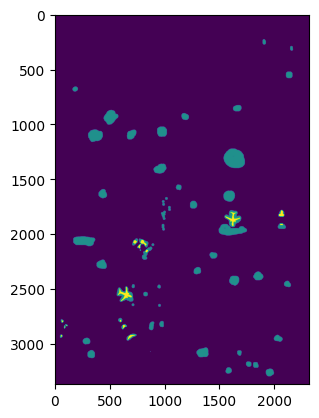

In [32]:
plt.imshow(labels)
plt.show()

In [40]:
m = np.load("whole_mean_all2.npy")
s = np.load("whole_std_all2.npy")
_ = viewer.add_image(m[0,1])
_ = viewer.add_image(s[0,1])

In [41]:
sm = np.load("parts_mean_all2.npy")
ss = np.load("parts_std_all2.npy")
_ = viewer.add_image(sm[0,1])
_ = viewer.add_image(ss[0,1])